## What-If Forecasts with "causal" inputs / S-Learner

This notebook demonstrates one of the simplest techniques for handling causal effects and producing what-if forecasts: using the causal drivers as features in the model.

We will use synthetic data to demonstrate the idea, where we simulate demand time series for items that are modulated by price (encoded in the form of discounts for a base price). Here, the discounts are chosen at random, so there is no confounding (the main problem that would necessitate more complex approaches). However, this approach can also work well in practice. 

In [264]:
import gluonts
gluonts.__version__

'0.11.8'

In [265]:
import os
from datetime import datetime
from pathlib import Path

import numpy as np
import torch
import random

In [283]:
# fix random seeds for reproducibility
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

In [284]:
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
from gluonts.dataset.util import to_pandas
from gluonts.torch.model.deepar import DeepAREstimator
from gluonts.dataset.artificial import recipe as rcp

plt.rcParams["figure.figsize"] = (16, 6)

# Synthetic Data Generation

We will use the synthetic data generation capabilities of GluonTS to generate a somewhat realistic data set of time series consisting of scale, level, trend, seasonality, and a discount-based price mechanism with random elasticity. We assume that the change in demand is linear in the change in price. We use Poisson noise as the noise model here, which is somewhat unrealistic, but makes the effects easier to discern (for both humans and the forecasting algorithm). 

In [285]:
# helper function for plotting synthetic data generation recipes
def plot_recipe(recipe, length):
    output_dict = rcp.evaluate(recipe, length)
    K = len(output_dict)
    lct = MultipleLocator(365.25)
    minor = AutoMinorLocator(12)

    fig, axs = plt.subplots(K, 1, figsize=(16, 2 * len(recipe)))
    for i, k in enumerate(output_dict):
        axs[i].xaxis.set_major_locator(lct)
        axs[i].xaxis.set_minor_locator(minor)
        axs[i].plot(output_dict[k])
        axs[i].grid()
        axs[i].set_ylabel(k)

In [286]:
# configure the different components that make up our time seris
slope = rcp.RandomUniform(low=0, high=3, shape=(1,))
offset = rcp.RandomUniform(low=0, high=3, shape=(1,))
trend = rcp.LinearTrend(slope=slope)
daily_smooth_seasonality = rcp.SmoothSeasonality(period=365, phase=-365/4)
scale = rcp.RandomUniform(low=0, high=1000, shape=1)
black_price = rcp.RandomUniform(low=10.0, high=100.0, shape=(1,))

# we choose the discount level by summing 7 independent binary Markov chains
discounts = [rcp.BinaryMarkovChain(0.003, 0.003) for i in range(7)]
discount = (7.0 - sum(discounts)) / 10.0
price = (1.0 - discount) * black_price
plain_target = scale * (offset + trend + daily_smooth_seasonality)
price_elasticity = rcp.RandomUniform(low=-10, high=0, shape=(1,))
relative_change_in_demand = 1 - price_elasticity * discount
target = rcp.lifted_numpy.random.poisson(relative_change_in_demand * plain_target)

# this is just for plotting below
recipe_with_intermediates = {
    "trend": trend,
    "daily_smooth_seasonality": daily_smooth_seasonality,
    "plain_target": plain_target,
    "discount": discount,
    "price": price,
    "relative_change_in_demand": relative_change_in_demand,
    "target": target
}

# this is the recipe we'll use to generate the actual data
recipe = {
    "feat_dynamic_real": [discount],  # add the discount as our only feature
    "target": target
}

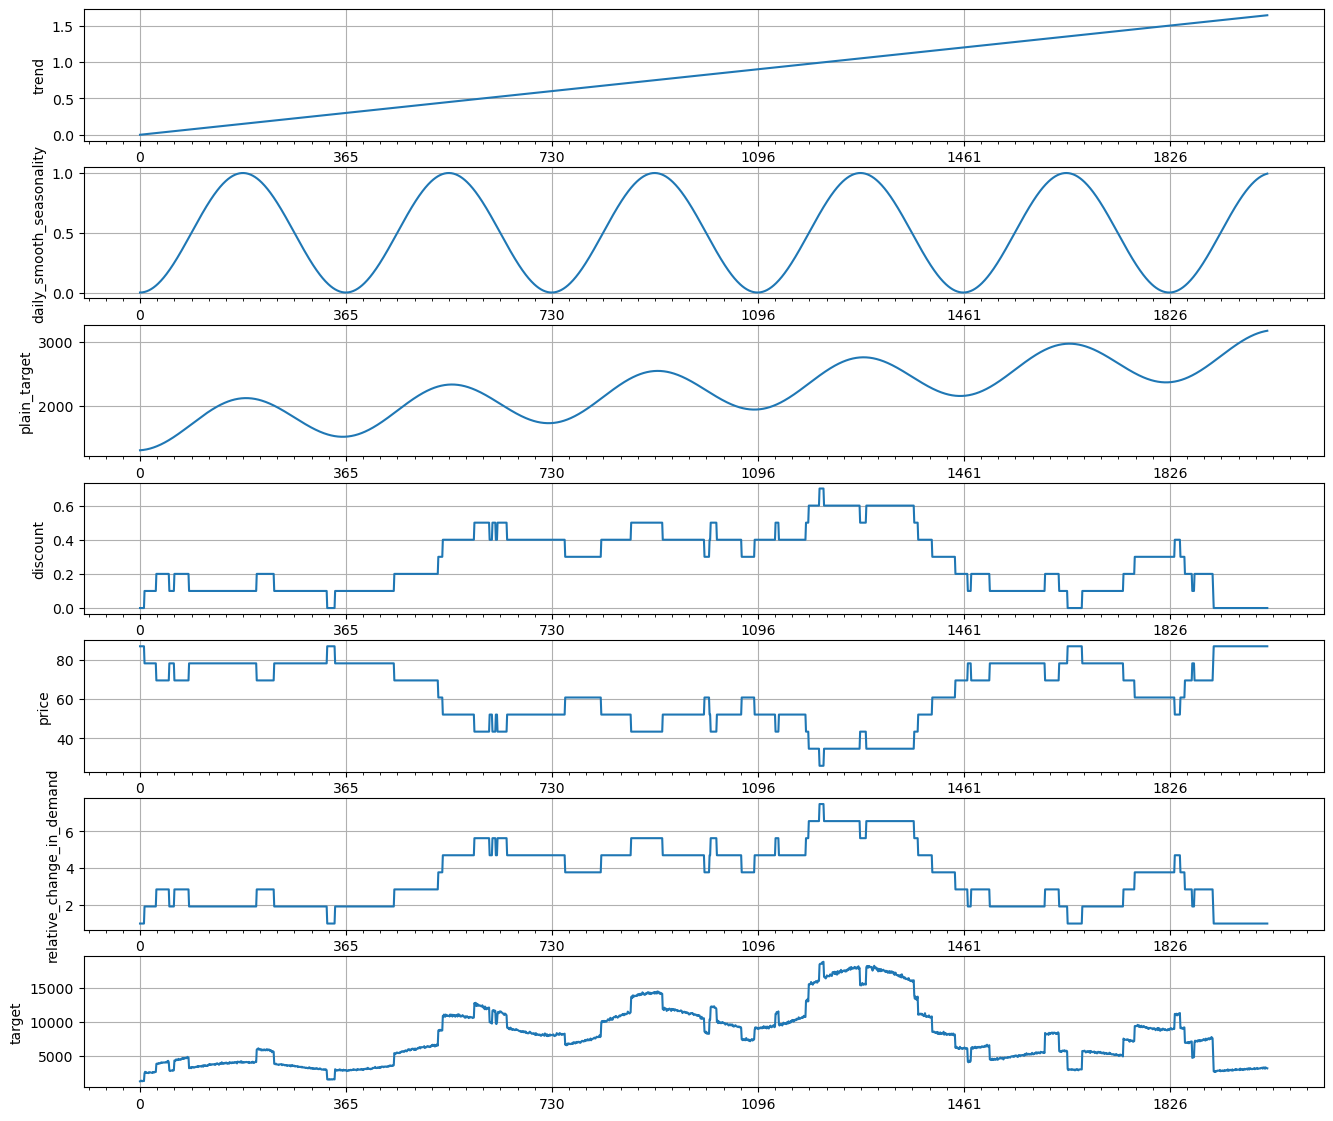

In [287]:
plot_recipe(recipe_with_intermediates, 2000)

In [288]:
from gluonts.dataset.common import ListDataset

NUM_TS = 1000
TS_LENGTH = 4 * 365

dataset = ListDataset(rcp.take_as_list(rcp.generate(TS_LENGTH, recipe, "2018-01-01", {}), NUM_TS), freq='1D')

## Split Dataset Into a Train and Test Time Period

In [289]:
from gluonts.dataset.split import split
prediction_length = 7
train, test_template = split(dataset, offset=-prediction_length)
test = test_template.generate_instances(prediction_length=prediction_length)
test_list = list(test)

## Model Setup

We'll use DeepAR as our forecasting model. We'll configure just a single dynamic feature (the discount), and fix the lags to a single seasonality period (for simplicity). The rest of the configuration is fairly standard and not particularly tuned, but is sufficient for illustration.

In [290]:
from gluonts.torch.distributions.distribution_output import NegativeBinomialOutput


estimator_deepar = DeepAREstimator(
     "D", 
     prediction_length=prediction_length, 
     context_length=7 * 2,
     num_layers=2,
     hidden_size = 40,
     distr_output=NegativeBinomialOutput(),
     num_feat_dynamic_real=1, 
     num_feat_static_real=0, 
     num_feat_static_cat=0,
     cardinality = [],
     lags_seq=[365],
     lr=5e-3,
     batch_size=128,
     trainer_kwargs = {
         "precision": 64, 
         "max_epochs": 50
     }
)


## Train the Model

In [291]:
predictor_deepar = estimator_deepar.train(train)

/Users/jan/opt/miniconda3/envs/mfip2/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/jan/opt/miniconda3/envs/mfip2/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:200: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(
/Users/jan/opt/miniconda3/envs/mfip2/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:108: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(

  | Name  | Type        | Params | In sizes 

Training: 0it [00:00, ?it/s]

Epoch 0, global step 50: 'train_loss' reached 7.91503 (best 7.91503), saving model to '/Users/jan/Projects/ModernForecasting/notebooks_oct2023/lightning_logs/version_34/checkpoints/epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.34091 (best 7.34091), saving model to '/Users/jan/Projects/ModernForecasting/notebooks_oct2023/lightning_logs/version_34/checkpoints/epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 7.21370 (best 7.21370), saving model to '/Users/jan/Projects/ModernForecasting/notebooks_oct2023/lightning_logs/version_34/checkpoints/epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 7.09105 (best 7.09105), saving model to '/Users/jan/Projects/ModernForecasting/notebooks_oct2023/lightning_logs/version_34/checkpoints/epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 7.00482 (best 7.00482), saving model to '/Users/jan/Projects/ModernForecasting/notebooks_oct2023/li

## Inspect the Forecast

Before looking at the what-if analysis, let us inspect the forecasts that the model produces using the actually observed discount levels.

In [292]:
# compute forecasts for the test period of all time series 
forecasts_deepar = list(predictor_deepar.predict(test.input))

In [293]:
from gluonts.evaluation.backtest import _to_dataframe
tss = list(tqdm(map(_to_dataframe, test), total=len(test)))

  0%|          | 0/1000 [00:00<?, ?it/s]

In [294]:
def plot_prob_forecasts(ts_ent, forecast_ent):
    plot_length = 365
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [
        f"{k}% prediction interval" for k in prediction_intervals
    ][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_ent[-plot_length:].plot(ax=ax, color='blue')  # plot the time series
    forecast_ent.plot(prediction_intervals=prediction_intervals, color="green")
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

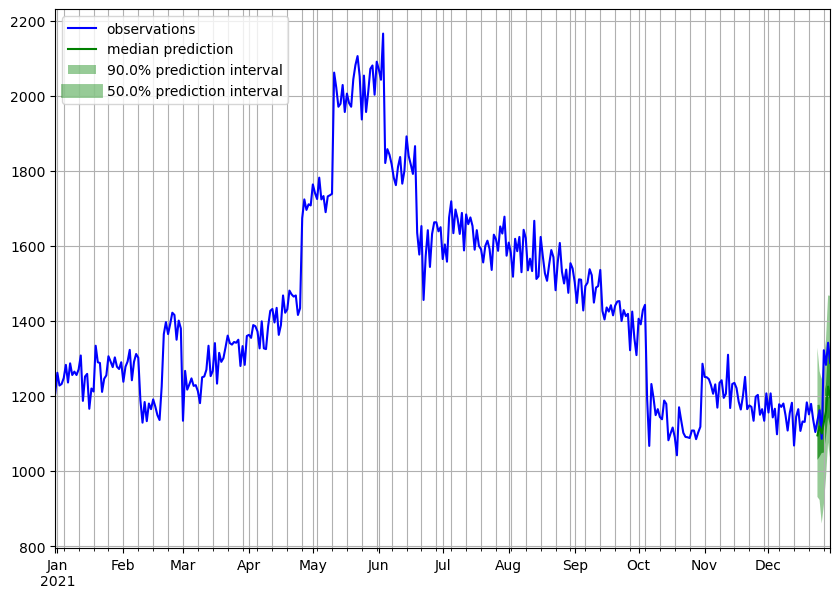

In [295]:
plot_prob_forecasts(tss[1], forecasts_deepar[1])

## What-If Analysis

In [296]:
# plotting utility to display discounts, forecasts and actuals
def plot_what_if(test_input, test_label, forecast):
    fig, ax = plt.subplots(1, 1, figsize=(16, 4))
    ax2 = ax.twinx()
    ax.set_ylim((-0.01, 1.01))

    # combine train/test parts for easier plotting
    full_series = pd.concat([to_pandas(test_input), to_pandas(test_label)])
    idx = full_series.index 
    
    # plot (part of) the observed train period
    full_series[-112:-7].plot(color="black", ax=ax2, label='actual')

    # plot discounts
    disc = test_input['feat_dynamic_real'][0]
    pd.Series(disc).set_axis(idx)[-112:-7].plot(ax=ax, color='orange', label='obs. discount')
    pd.Series(disc).set_axis(idx)[-7:].plot(ax=ax, color='red', label='set discount')

    # plot forecast
    ax2.plot(idx[-7:], forecast.median, color="black", linestyle="--", label='median forecast')
    ax2.plot(idx[-7:], forecast.quantile(0.1), color="blue", label='Q-0.1 forecast')
    ax2.plot(idx[-7:], forecast.quantile(0.9), color="red", label='Q-0.9 forecast')
    ax.legend()
    ax2.legend(loc='upper left')
    plt.grid(which='both')
    plt.show()

In [297]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [298]:
EXAMPLE_IDX = 2  # change to inspect other time series

@interact(d=widgets.FloatSlider(min=1e-3, max=1-1e-3, step=0.05, value=0.05))
def plot_with_discount(d):
    test_input, test_label = test_list[EXAMPLE_IDX]
    
    # here is the key: change the feature (-> discount) values in the future to the scenario we want to consider
    test_input['feat_dynamic_real'][0] = np.concatenate((test_input['feat_dynamic_real'][0][:-7], d * np.ones(7)))
    
    # make a forecasts based on the modified input
    forecasts = list(predictor_deepar.predict([test_input]))
    
    plot_what_if(test_input, test_label, forecasts[0])

interactive(children=(FloatSlider(value=0.05, description='d', max=0.999, min=0.001, step=0.05), Output()), _d…